In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.io import ascii

from scipy import stats, interpolate
from scipy.integrate import quad, cumtrapz
from scipy.optimize import curve_fit

from magnification_library import *
import clmm
from clmm import utils 
import pyccl

In [2]:
from importlib import reload 
import magnification_library
reload (magnification_library)

from magnification_library import *

In [4]:
#define cosmology

#from https://arxiv.org/pdf/1904.13378.pdf%20for%20u-dropout BEWARE that CT backend can not handle sigma8

#astropy object
cosmo = FlatLambdaCDM(H0=67.7, Om0=0.265, Tcmb0=0 , Neff=3.04, m_nu=None, Ob0=0.0448)

#ccl object
cosmo_ccl = pyccl.Cosmology(Omega_c=cosmo.Om0-cosmo.Ob0, Omega_b=cosmo.Ob0,
                      h=cosmo.h, sigma8= 0.80, n_s=0.963)
#clmm object
cosmo_clmm = clmm.Cosmology(be_cosmo=cosmo_ccl)

In [5]:
def get_halo_concentration(mass_lens, z_lens, cosmo, cosmo_ccl, relation="Diemer15"):
    mdef = pyccl.halos.massdef.MassDef(200, 'critical', c_m_relation=relation)
    concdef = pyccl.halos.concentration.concentration_from_name(relation)()
    conc = concdef.get_concentration(cosmo=cosmo_ccl, M=mass_lens, a=cosmo.scale_factor(z_lens), mdef_other=mdef)
    return conc 

# **1) Lens and sources properties**

## **Lens**

In [10]:
#lens properties 
z_cl = [0.1, 0.3, 0.5, 0.7, 1.0, 1.2, 1.5]
M200_cl = np.array([5e13, 1e14, 2.5e14, 5e14,1e15])

r200, c200 = np.zeros((2, len(M200_cl), len(z_cl)))
for i in range(len(z_cl)):
    r200[:, i] = scaled_radius(200, M200_cl, z_cl[i], cosmo)
    
c200 = np.zeros((len(M200_cl),len(z_cl)))
for i in np.arange(len(z_cl)):
    for j in np.arange(len(M200_cl)):
        c200[j,i] = get_halo_concentration(M200_cl[j], z_cl[i], cosmo, cosmo_ccl, "Diemer15")
    

Text(0, 0.5, 'c200')

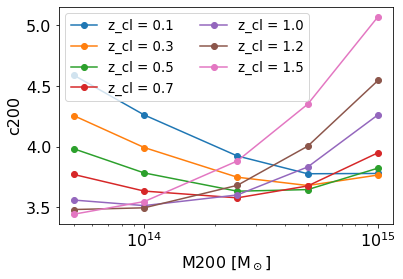

In [11]:
for i in range(len(z_cl)):
    plt.semilogx(M200_cl, c200[:,i], 'o-',  label = 'z_cl = '+str(z_cl[i]));

plt.legend(ncol=2, fontsize='small')

plt.xlabel('M200 [M$_\odot$]')
plt.ylabel('c200')

## lens expected number counts 

In [12]:
mass_def = pyccl.halos.MassDef200m()
hmf = pyccl.halos.MassFuncTinker10(cosmo_ccl, mass_def = mass_def) #dn/dlog10M
#corr = 1./(M200_cl*np.log(10)) #pour passer en dn/dM
corr = 1

In [13]:
Area = 18000 * u.deg**2
Omega = Area.to(u.sr)

X = pyccl.comoving_radial_distance(cosmo_ccl, a = 1./(1+np.array(z_cl))) * u.Mpc
Hz = pyccl.background.h_over_h0(cosmo_ccl, 1/(1+np.array(z_cl) )) * cosmo_ccl.cosmo.params.H0

dVdz = 1/u.sr *  (pyccl.physical_constants.CLIGHT * u.m/u.s ).to(u.km/u.s)  / (Hz * u.km/(u.Mpc*u.s)) *  X**2 
# similar to  cosmo.be_cosmo.differential_comoving_volume(np.array(z_cl))

Volume = dVdz * Omega

In [14]:
N_hmf = np.array([corr * hmf.get_mass_function(cosmo_ccl, M200_cl, 1./(1+np.array(z_cl[i])) ) for i in range(len(z_cl))])
N_halo = np.array([N_hmf[i,:] * Volume[i].value for i in range(len(z_cl))])

Text(0, 0.5, 'M200 [$M_{\\odot}$]')

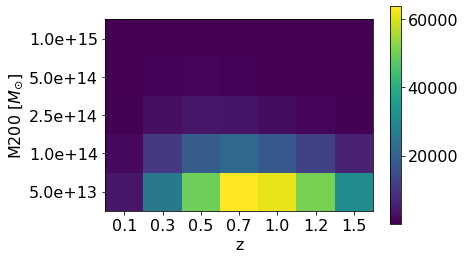

In [15]:
dz = 0.05*2
dlog10m = 0.1
#dm = 0.5*1e13


plt.imshow(N_halo.T*dz*dlog10m,origin='lower')#,extent = [np.array(z_cl).min(), np.array(z_cl).max(), np.array(M200_cl).min(), np.array(M200_cl).max()], aspect='auto')
plt.xticks(np.arange(0,len(z_cl)), [0.1, 0.3, 0.5, 0.7, 1.0, 1.2, 1.5])
plt.yticks(np.arange(0,len(M200_cl)), ['5.0e+13', '1.0e+14', '2.5e+14', '5.0e+14', '1.0e+15'])
plt.colorbar()
plt.xlabel('z')
plt.ylabel('M200 [$M_{\odot}$]')

## **Sources**

In [20]:
#Source galaxies properties 
#(source shear shot noise or LF slope, source density, redshift distribution parametrization)

#SHEAR LSST__________________________________________________________________
# fiducial number for Y10 (Y1) after blending + masking https://arxiv.org/pdf/1305.0793.pdf
s_e = 0.26
n_e_Y10 = 26 /u.arcmin**2
n_e_Y1 = 9 /u.arcmin**2

def shear_pdz(z):
    norm =quad(lambda z: trunc_pdf(z, 1.24, 1.01, 0.51, 0, 3), 0, np.inf)[0]
    return pdf_z(z, 1.24, 1.01, 0.51)*np.heaviside(z>0,0)*np.heaviside(z<3.,0)/norm

#MAGNIFICATION LSST u-dropout_________________________________________________________
#see Fig 6 in https://arxiv.org/pdf/1904.13378.pdf for u-dropout

LF_param = {'z_eff':[2.,3.,3.8,4.9,5.9], 'phi_star':[97.0,50.4,92.5,32.2,16.4]*1/(cosmo.h*u.Mpc**3), 'alpha':[-1.60,-1.78,-1.57,-1.60,-1.87], 'm_star_UV':[24.2,24.7,25.4,25.5,25.8]}

#At z~3 the LSST band corresponding to UV ~ 1500 Angstrom is the r band.
#limiting mag from C1 in https://arxiv.org/pdf/1809.01669.pdf
mlimY1 = 25.81 #r band
mlimY10 = 27.04 #r band

alpha_lbg_Y1 = 2.5 * slope(mlimY1, LF_param['alpha'][1], LF_param['m_star_UV'][1], beta=None,fct="schechter")
alpha_lbg_Y10 = 2.5 * slope(mlimY10, LF_param['alpha'][1], LF_param['m_star_UV'][1], beta=None,fct="schechter")
n_eff_lbg_Y1 = (1.8e4/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 
n_eff_lbg_Y10 = (7.5*1e4/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 

def mu_lbg_pdz(z):
    func = gaussian(z, 1, 2.96,0.61/(2*np.sqrt(2*np.log(2))))
    return func/quad(lambda z: gaussian(z, 1, 2.96,0.61/(2*np.sqrt(2*np.log(2)))), 0, np.inf)[0]


#MAGNIFICATION LSST BX-dropout_________________________________________________________
#see Fig 6 in https://arxiv.org/pdf/1904.13378.pdf for BX-dropouts

#At z~2 the LSST band corresponding to UV ~ 1500 Angstrom is the g band.
#limiting mag from C1 in https://arxiv.org/pdf/1809.01669.pdf
mlimY1g =  25.60 #g band
mlimY10g = 27.84 #g band

alpha_bx_Y1 = 2.5 * slope(mlimY1g, LF_param['alpha'][0], LF_param['m_star_UV'][0], beta=None,fct="schechter")
alpha_bx_Y10 = 2.5 * slope(mlimY10g, LF_param['alpha'][0], LF_param['m_star_UV'][0], beta=None,fct="schechter")

n_eff_bx_Y1 = (3e4/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 
n_eff_bx_Y10 = (3.*1e5/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 

def mu_bx_pdz(z):
    func = gaussian(z, 1, 2.20,0.80/(2*np.sqrt(2*np.log(2))))
    return func/quad(lambda z: gaussian(z, 1, 2.20,0.80/(2*np.sqrt(2*np.log(2)))), 0, np.inf)[0]


#MAGNIFICATION Euclid/WFIRST Halpha_________________________________________________________
#https://arxiv.org/pdf/1710.00833.pdf

alpha_ha =  2. #based on manual check
n_eff_ha = (0.5 * 4256./(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) 
#based on 1/3 * (counts_Ferr + counts_Cal + counts_Char) f>2x10^{-16} + 50% estimation probability to measure the redshift

def halpha_pdz(z):
    """Redshift distribution function"""
    #func = np.heaviside((z>0.9),0)*np.heaviside((z<1.8),0)*(z**0.106482)*np.exp(-(z/0.58316767))
    func = np.heaviside((z>0.9),0)*np.heaviside((z<1.8),0)*(z**0.106482)*np.exp(-(z/0.58316767))
    return func/quad(lambda z: np.heaviside((z>0.9),0)*np.heaviside((z<1.8),0)*(z**0.106482)*np.exp(-(z/0.58316767)), 0, np.inf)[0]

#MAGNIFICATION DESI QSO_________________________________________________________
alpha_qso =  2.5 *0.197 #for QSO based on last raw of Table 1 in https://www.aanda.org/articles/aa/pdf/2017/12/aa31850-17.pdf
n_eff_qso = (170/(u.deg*u.deg)).to(1/(u.arcmin*u.arcmin)) #based on Table 3.1 in https://arxiv.org/pdf/1611.00036.pdf (measured redshift)

def mu_qso_pdz(z):
    norm =quad(QSO_pdf_z, 0, np.inf)[0]
    return QSO_pdf_z(z)/norm

mslope_z = -99

# **2) Model computation**

In [21]:
n_e = n_e_Y10
n_eff_dmu = n_eff_bx_Y10
alpha_dmu = alpha_bx_Y10
dmu_pdz = mu_bx_pdz

dict_profile = {'reduced shear': \
                {'model_func':  clmm.theory.compute_tangential_shear, \
                'noise_func': lambda Ngal: noise_shear(Ngal , s_e),\
                'model_arg': 1., \
                'source_pdz': shear_pdz,\
                'source_density': n_e,\
                'delta_z_cut' : 0.1}, \
                'density contrast': \
                {'model_func':  clmm.theory.compute_convergence, \
                'noise_func': noise_mag,\
                'model_arg': 2 * abs(alpha_dmu-1), \
                'source_pdz': dmu_pdz,\
                'source_density': n_eff_dmu,\
                'delta_z_cut' : 0.1}, \
                'redshift depth contrast': \
                {'model_func':  clmm.theory.compute_magnification, \
                'noise_func': lambda Ngal: noise_zdepth(Ngal , mu_qso_pdz),\
                'model_arg': 2.5*mslope_z, \
                'source_pdz': mu_qso_pdz,\
                'source_density': n_eff_qso,\
                'delta_z_cut' : 0.1}}

In [22]:
lens_redshift = z_cl
radial_unit, rmin, rmax = 'Mpc', 0.2, 3.5
nbins = 7
method = 'evenlog10width'

In [26]:
bin_center_s, noise_s = np.zeros((2, nbins, len(lens_redshift)))
bin_edges_s = np.zeros((nbins + 1, len(lens_redshift)))
model_s = np.zeros((nbins, len(M200_cl), len(lens_redshift)))

for i in range(len(lens_redshift)):
    conc = get_halo_concentration(M200_cl, lens_redshift[i], cosmo, cosmo_ccl, "Diemer15")
    bin_center_s[:,i], bin_edges_s[:,i], noise_s[:,i], model_s[:,:,i] = \
    profile_determination(rmin, rmax, radial_unit , lens_redshift[i], M200_cl , "reduced shear",\
                          dict_profile, cosmo_clmm,   nbins=nbins, method=method,\
                          conc=conc, delta_mdef=200, zinf=1000)

In [29]:
bin_center_mu_lbg, noise_mu_lbg = np.zeros((2, nbins, len(lens_redshift)))
bin_edges_mu_lbg = np.zeros((nbins + 1, len(lens_redshift)))
model_mu_lbg = np.zeros((nbins, len(M200_cl), len(lens_redshift)))

for i in range(len(lens_redshift)):
    conc =  get_halo_concentration(M200_cl, lens_redshift[i], cosmo, cosmo_ccl, "Diemer15")
    bin_center_mu_lbg[:,i], bin_edges_mu_lbg[:,i], noise_mu_lbg[:,i] , model_mu_lbg[:,:,i] = \
            profile_determination(rmin, rmax, radial_unit , lens_redshift[i], M200_cl ,\
                                  "density contrast" , dict_profile, cosmo_clmm,   nbins=nbins, method=method,\
                                  conc=conc, delta_mdef=200, zinf=1000)

In [31]:
bin_center_mu_qso, noise_mu_qso = np.zeros((2, nbins, len(lens_redshift)))
bin_edges_mu_qso = np.zeros((nbins + 1, len(lens_redshift)))
model_mu_qso = np.zeros((nbins, len(M200_cl), len(lens_redshift)))
modelz_mu_qso = np.zeros((nbins, len(M200_cl), 10000, len(lens_redshift)))

for i in range(len(lens_redshift)):
    conc =  get_halo_concentration(M200_cl, lens_redshift[i], cosmo, cosmo_ccl, "Diemer15")
    bin_center_mu_qso[:,i], bin_edges_mu_qso[:,i], noise_mu_qso[:,i], model_mu_qso[:,:,i], modelz_mu_qso[:,:,:,i] = \
            profile_determination(rmin, rmax, radial_unit , lens_redshift[i], M200_cl ,\
                                  "redshift depth contrast" ,dict_profile, cosmo_clmm,   nbins=nbins, method=method ,\
                                  conc=conc, delta_mdef=200, zinf=1000)

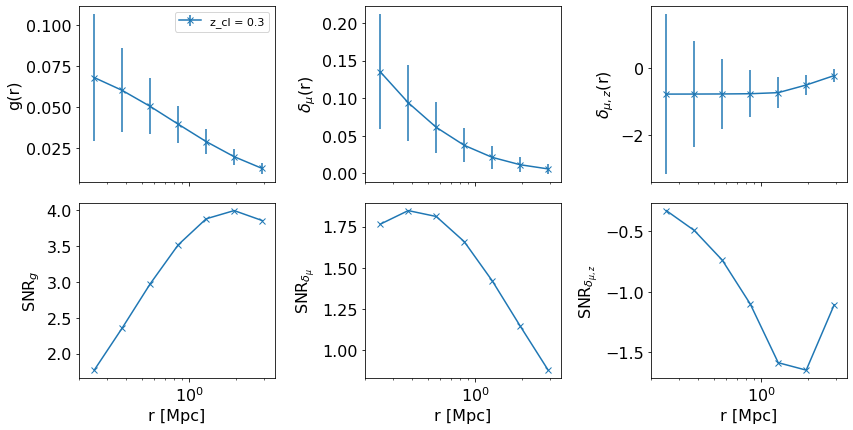

In [32]:
fig, ax = plt.subplots(2, 3,  figsize=(12,6), sharex=True, sharey=False)

i,j = 4,1

ax[0,0].errorbar(bin_center_s[:,j], model_s[:,i, j], yerr = noise_s[:,j], fmt='-x',  label = 'z_cl = '+str(lens_redshift[j]))
ax[1,0].plot(bin_center_s[:,j], model_s[:,i, j]/noise_s[:,j],'-x',  label = 'z_cl = '+str(lens_redshift[j]))

ax[0,1].errorbar(bin_center_mu_lbg[:,j], model_mu_lbg[:,i, j], yerr = noise_mu_lbg[:,j], fmt='-x',  label = 'z_cl = '+str(lens_redshift[j]))
ax[1,1].plot(bin_center_mu_lbg[:,j], model_mu_lbg[:,i, j]/noise_mu_lbg[:,j],'-x',  label = 'z_cl = '+str(lens_redshift[j]))

ax[0,2].errorbar(bin_center_mu_qso[:,j], model_mu_qso[:,i, j], yerr = noise_mu_qso[:,j], fmt='-x',  label = 'z_cl = '+str(lens_redshift[j]))
ax[1,2].plot(bin_center_mu_qso[:,j], model_mu_qso[:,i, j]/noise_mu_qso[:,j],'-x',  label = 'z_cl = '+str(lens_redshift[j]))


ax[0,0].set_xlim(0.2, 3.5)
ax[0,0].legend(ncol=2, fontsize='x-small', loc="best")
ax[0,0].set_xscale('log')

ax[0,0].set_ylabel('g(r)')
ax[1,0].set_ylabel('SNR$_g$')

ax[0,1].set_ylabel('$\delta_{\mu}$(r)')
ax[1,1].set_ylabel('SNR$_{\delta_{\mu}}$')

ax[0,2].set_ylabel('$\delta_{\mu,z}$(r)')
ax[1,2].set_ylabel('SNR$_{\delta_{\mu,z}}$')

fig.tight_layout()

[ax[1,i].set_xlabel('r [' + radial_unit + ']') for i in [0,1,2]];

# TEST

In [33]:
def truncated_zpdf(z, zpdz, zmin, zmax=None):
    if zmax ==None:
        zmax = 1e10

    return zpdz(z) * np.heaviside((z>zmin),0)*np.heaviside((z<zmax),0)


In [34]:
lens_redshift[6]

1.5

In [36]:
test = profile_determination(rmin, rmax, radial_unit , lens_redshift[6], M200_cl , "redshift depth contrast",\
                          dict_profile, cosmo_clmm,   nbins=nbins, method=method,\
                          conc=conc, delta_mdef=200, zinf=1000)

/pbs/throng/lsst/users/mricci/desc/CLMM/clmm/theory/func_layer.py:532: UserWarning: Some source redshifts are lower than the cluster redshift. magnification = 1 for those galaxies.
  warnings.warn(


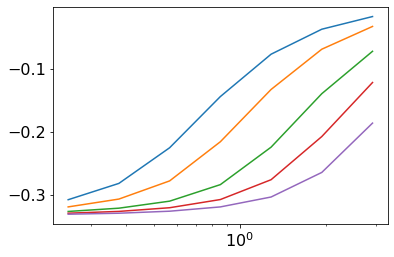

In [37]:
[plt.semilogx(test[0], test[3][:,i]) for i in range(5)];

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

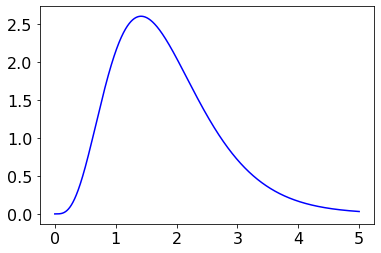

In [38]:
zmin, zmax, nz = 0.001, 5, 10000
z = np.linspace(zmin, zmax, nz)
        
plt.plot(z, dict_profile["redshift depth contrast"]['source_pdz'](z)/np.mean(dict_profile["redshift depth contrast"]['source_pdz'](z)),'b')
plt.plot(z, dict_profile["redshift depth contrast"]['source_pdz'](z)*test[3][1][0,4]/np.mean(dict_profile["redshift depth contrast"]['source_pdz'](z)*test[3][1][0,4]),'r')
plt.plot(z, dict_profile["redshift depth contrast"]['source_pdz'](z)*test[3][1][3,0]/np.mean(dict_profile["redshift depth contrast"]['source_pdz'](z)*test[3][1][3,0]))

plt.axvline(lens_redshift[6])

In [39]:
zt = np.sum(z*dict_profile["redshift depth contrast"]['source_pdz'](z))/np.sum(dict_profile["redshift depth contrast"]['source_pdz'](z))
zt

1.8142758143331978

In [40]:
zt_trunc = np.sum(z[z>lens_redshift[6]]*dict_profile["redshift depth contrast"]['source_pdz'](z[z>lens_redshift[6]]))/ np.sum(dict_profile["redshift depth contrast"]['source_pdz'](z[z>lens_redshift[6]]))
zt_trunc 

2.3257200933419258

In [41]:
zm = np.sum(z*test[3][1][:,2]*dict_profile["redshift depth contrast"]['source_pdz'](z),axis=1)/np.sum(test[3][1][:,2]*dict_profile["redshift depth contrast"]['source_pdz'](z),axis=1)
zm

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [481]:
ind = np.where((z>lens_redshift[6]+0.5))[0]
zm_trunc = np.sum(z[z>lens_redshift[6]+0.5]*test[3][1][:,2,ind]*dict_profile["redshift depth contrast"]['source_pdz'](z[z>lens_redshift[6]+0.5]),axis=1)/np.sum(test[3][1][:,2,ind]*dict_profile["redshift depth contrast"]['source_pdz'](z[z>lens_redshift[6]+0.5]),axis=1)
zm_trunc

array([3.12092025, 2.96096788, 2.84680081, 2.77976019, 2.74446767,
       2.72701831, 2.71872168])

In [475]:
zm/zt - 1

array([0.68574511, 0.47364122, 0.25759908, 0.12471599, 0.05826635,
       0.02684331, 0.01224517])

In [482]:
zm_trunc/zt_trunc - 1

array([0.34191568, 0.27314026, 0.22405135, 0.1952256 , 0.18005072,
       0.17254794, 0.16898061])

In [479]:
zm_trunc/zt_trunc - 1

array([0.32882154, 0.2271365 , 0.14098039, 0.08703997, 0.05824329,
       0.04397743, 0.03718641])

In [477]:
zm_trunc/zt_trunc - 1

array([0.32736066, 0.21918755, 0.12367081, 0.06286968, 0.03031575,
       0.01419429, 0.00652272])

In [500]:
a = np.ones((7,3,100))
b = np.ones((7,100))

b[0,50:90]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# **3) $\chi^2$ minimization to constrain the mass**

In [565]:
def mass_minimization(chi2_val, mass_guess, s = np.array([1.,2.,3.]) ):
    chi2_val_itp_up = interpolate.interp1d(chi2_val[np.nanargmin(chi2_val) :], mass_guess[np.nanargmin(chi2_val) :], bounds_error= False)
    chi2_val_itp_low = interpolate.interp1d(chi2_val[: np.nanargmin(chi2_val) + 1], mass_guess[: np.nanargmin(chi2_val) + 1], bounds_error= False)
    
    chi2_eval = stats.chi2.ppf(stats.chi2.cdf(s**2,1), 1)
    
    eval_mass = mass_guess[np.nanargmin(chi2_val)]
    eval_mass_min = chi2_val_itp_low(np.nanmin(chi2_val) + stats.chi2.ppf(stats.chi2.cdf(s**2,1), 1))
    eval_mass_max = chi2_val_itp_up(np.nanmin(chi2_val)  + stats.chi2.ppf(stats.chi2.cdf(s**2,1), 1))
    
    return eval_mass, eval_mass_min, eval_mass_max

In [564]:
np.nanargmin

<function numpy.nanargmin(a, axis=None)>

In [530]:
def chi2 (data, error, model):
    chi2 = (data - model)**2/error**2
    return np.sum(chi2)

In [531]:
mass_guess = np.logspace(12,16,400, base=10)

In [533]:
model_guess_s, model_guess_mu_lbg, model_guess_mu_qso = np.zeros((3, bin_center_s[:,0].size, len(mass_guess), len(lens_redshift)))

for i in range(len(lens_redshift)):
    print("redhift", lens_redshift[i])
    conc_guess = get_halo_concentration(mass_guess, lens_redshift[i], cosmo.be_cosmo, cosmo_ccl, "Diemer15")
    model_guess_s[:,:,i]      = modele_determination(bin_center_s[:,0], radial_unit, lens_redshift[i], mass_guess, 'reduced shear', \
                                                     dict_profile, cosmo, conc=conc_guess, delta_mdef=200, zinf=1e10)
    model_guess_mu_lbg[:,:,i] = modele_determination(bin_center_s[:,0], radial_unit, lens_redshift[i], mass_guess, 'density contrast',\
                                                     dict_profile, cosmo, conc=conc_guess, delta_mdef=200, zinf=1e10)
    model_guess_mu_qso[:,:,i] = modele_determination(bin_center_s[:,0], radial_unit, lens_redshift[i], mass_guess, 'redshift depth contrast',\
                                                     dict_profile, cosmo, conc=conc_guess, delta_mdef=200, zinf=1e10)[0]

redhift 0.1
redhift 0.3


/pbs/throng/lsst/users/mricci/desc/Magnification_project/cluster_magnification/magnification_library.py:179: RuntimeWarning: invalid value encountered in power
  z_src_model='single_plane')**(dict_profile[profile_type]['model_arg']-1)


redhift 0.5
redhift 0.7
redhift 1.0
redhift 1.2
redhift 1.5


In [574]:
chi2_val_s = np.zeros((len(mass_guess), len(M200_cl),  len(lens_redshift)))
chi2_val_mu_lbg = np.zeros((len(mass_guess), len(M200_cl),  len(lens_redshift)))
chi2_val_mu_qso = np.zeros((len(mass_guess), len(M200_cl),  len(lens_redshift)))

N_S   = 1.
N_LBG = 1.
N_QSO = 1.

N_CL = np.ones((len(lens_redshift), len(M200_cl)))

N_CL = N_halo*dz*dlog10m

for i in range(len(lens_redshift)):
    for j in range(len(M200_cl)):
        for k in range(len(mass_guess)):
            chi2_val_s[k, j,i] = chi2(model_s[:,j,i], noise_s[:,i]/np.sqrt(N_CL[i,j]), model_guess_s[:,k,i])
            chi2_val_mu_lbg[k, j,i] = chi2(model_mu_lbg[:,j,i], noise_mu_lbg[:,i]/np.sqrt(N_CL[i,j]), model_guess_mu_lbg[:,k,i])
            chi2_val_mu_qso[k, j,i] = chi2(model_mu_qso[:,j,i], noise_mu_qso[:,i]/np.sqrt(N_CL[i,j]), model_guess_mu_qso[:,k,i])

In [575]:
eval_mass_s, eval_mass_min_s, eval_mass_max_s = np.zeros((3, len(M200_cl),  len(lens_redshift)))
eval_mass_mu_lbg, eval_mass_min_mu_lbg, eval_mass_max_mu_lbg = np.zeros((3, len(M200_cl),  len(lens_redshift)))
eval_mass_mu_qso, eval_mass_min_mu_qso, eval_mass_max_mu_qso = np.zeros((3, len(M200_cl),  len(lens_redshift)))

for i in range(len(lens_redshift)):
    for j in range(len(M200_cl)):
        eval_mass_s[j,i], eval_mass_min_s[j,i], eval_mass_max_s[j,i] = mass_minimization(chi2_val_s[:, j,i], mass_guess, s = 1.)
        eval_mass_mu_lbg[j,i], eval_mass_min_mu_lbg[j,i], eval_mass_max_mu_lbg[j,i] = mass_minimization(chi2_val_mu_lbg[:, j,i], mass_guess, s = 1.)
        eval_mass_mu_qso[j,i], eval_mass_min_mu_qso[j,i], eval_mass_max_mu_qso[j,i] = mass_minimization(chi2_val_mu_qso[:, j,i], mass_guess, s = 1.)

In [576]:
eval_mass_comb, eval_mass_min_comb, eval_mass_max_comb  = np.zeros((3, len(M200_cl),  len(lens_redshift)))
eval_mass_comb_mu, eval_mass_min_comb_mu, eval_mass_max_comb_mu  = np.zeros((3, len(M200_cl),  len(lens_redshift)))

for i in range(len(lens_redshift)):
    for j in range(len(M200_cl)):
        eval_mass_comb[j,i], eval_mass_min_comb[j,i], eval_mass_max_comb[j,i] = mass_minimization(chi2_val_s[:, j,i] + chi2_val_mu_lbg[:, j,i] + chi2_val_mu_qso[:, j,i], mass_guess, s = 1.)
        eval_mass_comb_mu[j,i], eval_mass_min_comb_mu[j,i], eval_mass_max_comb_mu[j,i] = mass_minimization(chi2_val_mu_lbg[:, j,i] + chi2_val_mu_qso[:, j,i], mass_guess, s = 1.)

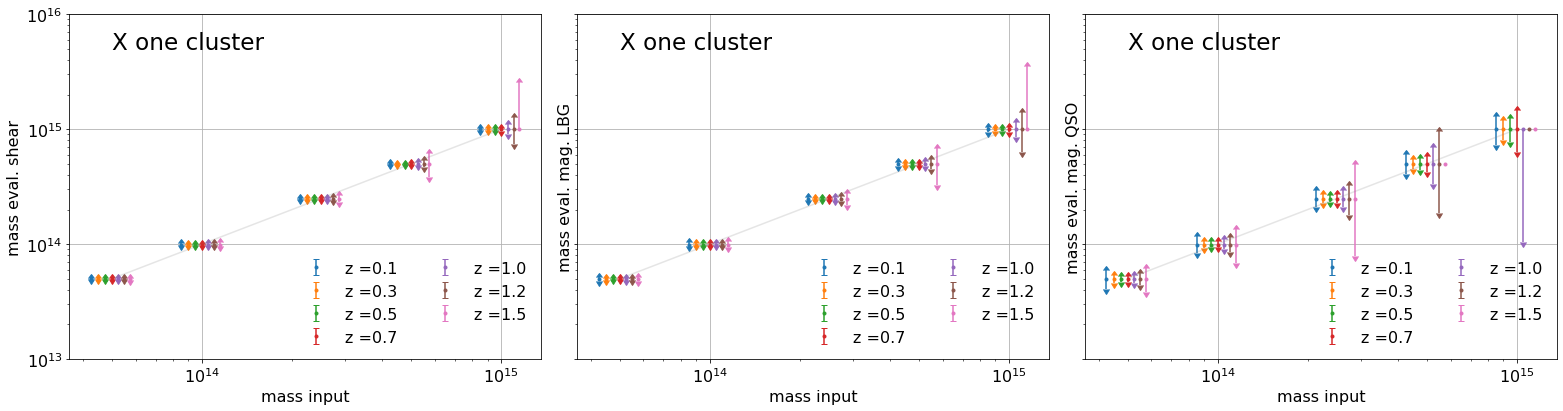

In [577]:
decal = 1 + np.linspace(-0.15,0.15,len(z_cl))

fig, (ax1, ax2, ax3) = plt.subplots(1,3,  figsize=(22,6), sharex=True, sharey=True)

[ax1.errorbar(M200_cl*decal[i], eval_mass_s[:,i], yerr = [eval_mass_s[:,i] - eval_mass_min_s[:,i], eval_mass_max_s[:,i] - eval_mass_s[:,i]], \
              lolims=True, uplims=True, fmt='.', label="z =" +str(z_cl[i])) for i in range(len(lens_redshift))];
[ax2.errorbar(M200_cl*decal[i], eval_mass_mu_lbg[:,i], yerr = [eval_mass_mu_lbg[:,i] - eval_mass_min_mu_lbg[:,i], eval_mass_max_mu_lbg[:,i] - eval_mass_mu_lbg[:,i]], lolims=True, uplims=True ,fmt='.', label="z =" +str(z_cl[i])) for i in range(len(lens_redshift))];
[ax3.errorbar(M200_cl*decal[i], eval_mass_mu_qso[:,i], yerr = [eval_mass_mu_qso[:,i] - eval_mass_min_mu_qso[:,i], eval_mass_max_mu_qso[:,i] - eval_mass_mu_qso[:,i]], lolims=True, uplims=True ,fmt='.', label="z =" +str(z_cl[i]) ) for i in range(len(lens_redshift))];
    
#[ax3.plot(M200_cl*decal[i], eval_mass_mu_qso[:,i],'.') for i in range(len(lens_redshift))];#, yerr = [eval_mass_mu_qso[:,i] - eval_mass_min_mu_qso[:,i], eval_mass_max_mu_qso[:,i] - eval_mass_mu_qso[:,i]], lolims=True, uplims=True ,fmt='.', label="z =" +str(z_cl[i]) ) for i in range(len(lens_redshift))];
  
    
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_ylabel("mass eval. shear");
ax2.set_ylabel("mass eval. mag. LBG");
ax3.set_ylabel("mass eval. mag. QSO");

for i in (ax1,ax2,ax3):
    i.plot(M200_cl, M200_cl,alpha=0.2)
    i.set_xlabel("mass input")
    i.grid()
    i.legend(loc='lower right',ncol=2,frameon=False)
    
#N_S = N_LBG = N_QSO = "expected LSST NC"
N_S = N_LBG = N_QSO = "one cluster"

ax1.text(5*1e13, 5e15, 'X ' + str(N_S), fontsize='x-large')
ax2.text(5*1e13, 5e15, 'X ' + str(N_LBG), fontsize='x-large')
ax3.text(5*1e13, 5e15, 'X ' + str(N_QSO), fontsize='x-large')

ax1.set_ylim(1e13,1e16)
fig.tight_layout()

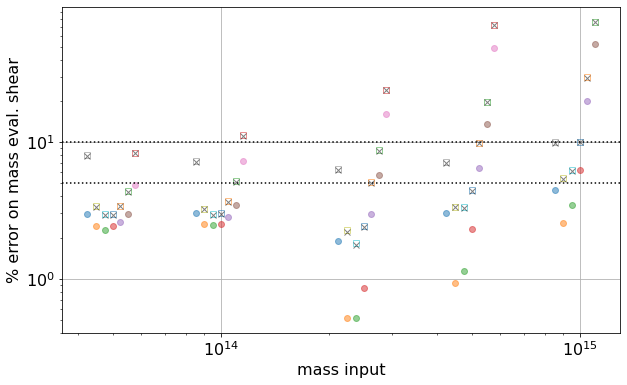

In [579]:
#relative error on mass from shear alone and shear + magnification (QSO & LBG) combined

fig, ax1= plt.subplots(1,1,  figsize=(10,6), sharex=True, sharey=True)

[ax1.plot(M200_cl*decal[i], 100*(eval_mass_max_s[:,i]  - eval_mass_min_s[:,i])/ eval_mass_s[:,i] ,'o', alpha=0.5, label="z =" +str(z_cl[i])) for i in range(len(lens_redshift))];
[ax1.plot(M200_cl*decal[i], 100*(eval_mass_max_mu_lbg[:,i]  - eval_mass_min_mu_lbg[:,i])/ eval_mass_mu_lbg[:,i] ,'s' ,mfc='None' , alpha=0.5, label="z =" +str(z_cl[i])) for i in range(len(lens_redshift))];
[ax1.plot(M200_cl*decal[i], 100*(eval_mass_max_comb_mu[:,i]  - eval_mass_min_comb_mu[:,i])/ eval_mass_comb_mu[:,i] ,'kx',alpha=0.5) for i in range(len(lens_redshift))];

ax1.set_xscale('log')
#ax1.set_yscale('log')

ax1.set_xlabel("mass input")
ax1.set_ylabel("% error on mass eval. shear");
ax1.grid()

#ax1.legend(loc='best',ncol=2,frameon=False)
ax1.axhline(5, color='black', linestyle='dotted')
ax1.axhline(10, color='black', linestyle='dotted')

ax1.set_yscale('log')

# **4) MCMC to constrain the mass and concentration**

In [77]:
def log_prior(params):
    log10mass0,log10conc0  = params
    if 20> log10mass0 > 10. and np.log10(20)>log10conc0>np.log10(0.1):
        return 0.0
    return -np.inf

In [78]:
from importlib import reload 
import magnification_library
reload (magnification_library)

from magnification_library import *

In [192]:
import emcee

def log_prob(params,data, error, lens_redshift):
    lp = log_prior(params)
    if log_prior(params)==-np.inf:
        return -np.inf
    log10mass0,log10conc0 = params
    mass0 = 10**(log10mass0)
    conc0 = 10**(log10conc0)
    model = modele_determination(bin_center_s[:,0], radial_unit, lens_redshift, mass0, 'reduced shear', dict_profile, cosmo, conc=conc0, delta_mdef=200, zinf=1e10,verbose=False)
    return -0.5 * chi2(data, error, model) 

In [195]:
import emcee

def log_prob_comb(params,data1,error1,data2,error2, lens_redshift):
    lp = log_prior(params)
    if log_prior(params)==-np.inf:
        return -np.inf
    log10mass0,log10conc0 = params
    mass0 = 10**(log10mass0)
    conc0 = 10**(log10conc0)
    model1 = modele_determination(bin_center_s[:,0], radial_unit, lens_redshift, mass0, 'reduced shear', dict_profile, cosmo, conc=conc0, delta_mdef=200, zinf=1e10,verbose=False)
    model2 = modele_determination(bin_center_mu_lbg[:,0], radial_unit, lens_redshift, mass0, 'density contrast', dict_profile, cosmo, conc=conc0, delta_mdef=200, zinf=1e10,verbose=False)
    return -0.5 * (chi2(data1, error1, model1) +  chi2(data2, error2, model2))

In [188]:
ndim, nwalkers = 2, 10
p0 = np.zeros((nwalkers,ndim))
p0[:,0] = np.random.randn(nwalkers) + 14
p0[:,1] = np.log10(3+np.random.randn(nwalkers))

In [193]:
i_test, j_test = 4,1
i,j=i_test, j_test 

print("Model tested with : z =", z_cl[j_test],", M200/1e14Msun = ", M200_cl[i_test]/1e14,", conc =", c200[i_test,j_test])


Model tested with : z = 0.3 , M200/1e14Msun =  10.0 , conc = 3.805675337218287


In [194]:
print("Model tested with : z =", z_cl[j_test],", M200/1e14Msun = ", M200_cl[i_test]/1e14,", conc =", c200[i_test,j_test])

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(model_s[:,i,j], noise_s[:,j], z_cl[j_test]))#/np.sqrt(N_CL[i,j])))
samp = sampler.run_mcmc(p0, 5000, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

Model tested with : z = 0.3 , M200/1e14Msun =  10.0 , conc = 3.805675337218287


100%|██████████| 5000/5000 [08:09<00:00, 10.22it/s]


In [196]:
sampler_comb = emcee.EnsembleSampler(nwalkers, ndim, log_prob_comb, args=(model_s[:,i,j], noise_s[:,j],model_mu_lbg[:,i,j], noise_mu_lbg[:,j], z_cl[j_test]))#/np.sqrt(N_CL[i,j])))
samp_2 = sampler_comb.run_mcmc(p0, 5000, progress=True)

100%|██████████| 5000/5000 [19:30<00:00,  4.27it/s]


In [197]:
samples = sampler.get_chain()
samples_comb = sampler_comb.get_chain()

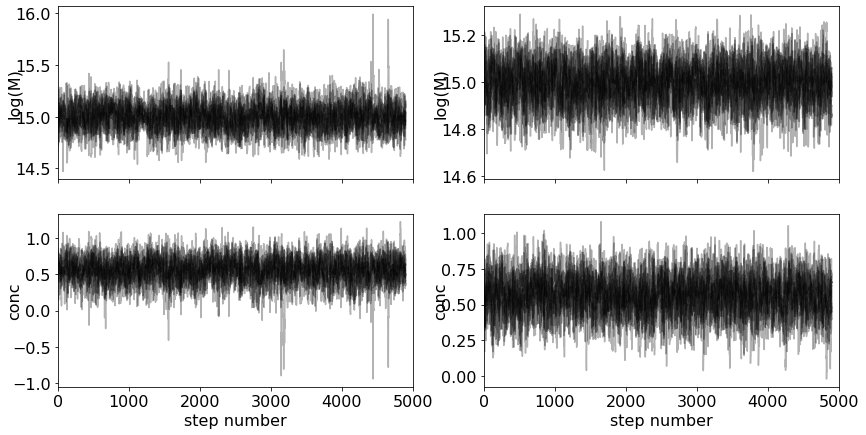

In [198]:
labels = ["log(M)", "conc"]
fig, axes = plt.subplots(2,2, figsize=(14, 7), sharex=True)

burn = 100
for i in range(ndim):
    ax = axes[i,0]
    ax.plot(samples[burn:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

    ax1 = axes[i,1]
    ax1.plot(samples_comb[burn:, :, i], "k", alpha=0.3)
    ax1.set_xlim(0, len(samples))
    ax1.set_ylabel(labels[i])
    ax1.yaxis.set_label_coords(-0.1, 0.5)
    
    
axes[-1,0].set_xlabel("step number");
axes[-1,1].set_xlabel("step number");

In [202]:
tau = sampler.get_autocorr_time()
print(tau)

[35.13204966 32.16597963]


In [203]:
tau_comb = sampler_comb.get_autocorr_time()
print(tau_comb)

[30.37063427 39.58889344]


In [215]:
thin = 35

flat_samples = sampler.get_chain(discard=100, thin=thin, flat=True)
print(flat_samples.shape)

flat_samples_comb = sampler_comb.get_chain(discard=100, thin=thin, flat=True)
print(flat_samples_comb.shape)

(1400, 2)
(1400, 2)


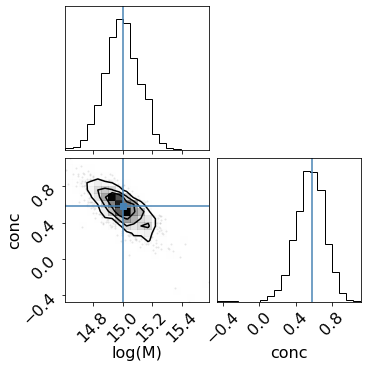

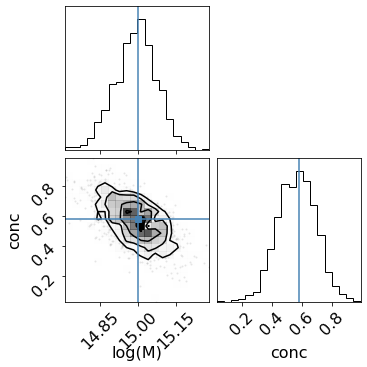

In [205]:
import corner

i,j= i_test, j_test 
fig = corner.corner(
    flat_samples, labels=labels, truths=[np.log10(M200_cl[i]), np.log10(c200[i,j])]
);

fig = corner.corner(
    flat_samples_comb, labels=labels, truths=[np.log10(M200_cl[i]), np.log10(c200[i,j])]
);

In [216]:
log_proba = sampler.get_log_prob(discard=100, thin=thin, flat=True)
log_proba_comb = sampler_comb.get_log_prob(discard=100, thin=thin, flat=True)

In [217]:
10**np.percentile(flat_samples[:,0],16)/1e15,10**np.percentile(flat_samples[:,0],84)/1e15

(0.7629761514331874, 1.2980964624739442)

In [218]:
10**np.percentile(flat_samples[:,1],16), 10**np.percentile(flat_samples[:,1],84)

(2.5203210642888063, 5.134215791242198)

In [219]:
10**flat_samples[np.argmax(log_proba),0], 10**flat_samples[np.argmax(log_proba),1]

(986402090707618.1, 3.827052364788417)

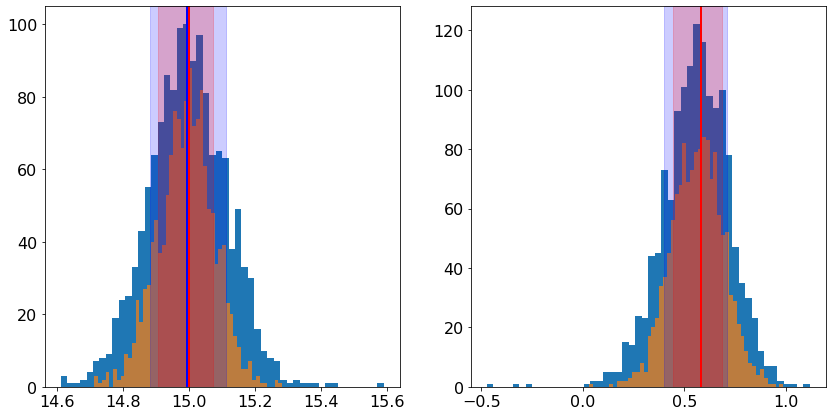

In [221]:
fig, axes = plt.subplots(1,2, figsize=(14, 7))

axes[0].hist(flat_samples[:,0],bins=50);
axes[0].hist(flat_samples_comb[:,0],bins=50,alpha=0.7);
axes[0].axvline(np.log10(M200_cl[i]),lw=2,color='black')
axes[0].axvspan(np.percentile(flat_samples[:,0],16),np.percentile(flat_samples[:,0],84),alpha=0.2,color="blue")
axes[0].axvspan(np.percentile(flat_samples_comb[:,0],16),np.percentile(flat_samples_comb[:,0],84),alpha=0.2,color="red")
axes[0].axvline(flat_samples[np.argmax(log_proba),0], lw=2, color='blue')
axes[0].axvline(flat_samples_comb[np.argmax(log_proba_comb),0], lw=2, color='red')

axes[1].hist(flat_samples[:,1],bins=50);
axes[1].hist(flat_samples_comb[:,1],bins=50,alpha=0.7);
axes[1].axvline(np.log10(c200[i,j]),lw=2,color='black')
axes[1].axvspan(np.percentile(flat_samples[:,1],16),np.percentile(flat_samples[:,1],84),alpha=0.2,color="blue")
axes[1].axvspan(np.percentile(flat_samples_comb[:,1],16),np.percentile(flat_samples_comb[:,1],84),alpha=0.2,color="red")
axes[1].axvline(flat_samples[np.argmax(log_proba),1], lw=2, color='blue')
axes[1].axvline(flat_samples_comb[np.argmax(log_proba_comb),1], lw=2, color='red')


In [238]:
model_BF_s_comb  = modele_determination(bin_center_s[:,0], radial_unit, z_cl[j_test], 10**flat_samples_comb[np.argmax(log_proba_comb),0], 'reduced shear', \
                                                     dict_profile, cosmo, conc=10**flat_samples_comb[np.argmax(log_proba_comb),1], delta_mdef=200, zinf=1e10)

model_BF_s  = modele_determination(bin_center_s[:,0], radial_unit, z_cl[j_test], 10**flat_samples[np.argmax(log_proba),0], 'reduced shear', \
                                                     dict_profile, cosmo, conc=10**flat_samples[np.argmax(log_proba),1], delta_mdef=200, zinf=1e10)


model_BF_mu_comb = modele_determination(bin_center_s[:,0], radial_unit, z_cl[j_test], 10**flat_samples_comb[np.argmax(log_proba_comb),0], 'density contrast',\
                                                     dict_profile, cosmo, conc=10**flat_samples_comb[np.argmax(log_proba_comb),1], delta_mdef=200, zinf=1e10)


                    

In [332]:
model_s_only= np.zeros((model_BF_s.size, flat_samples.shape[0] ))

for i in range(flat_samples_comb.shape[0]):

    model_s_only[:,i]  = modele_determination(bin_center_s[:,0], radial_unit, z_cl[j_test], 10**flat_samples[i,0], 'reduced shear', \
                                                     dict_profile, cosmo, conc=10**flat_samples[i,1], delta_mdef=200, zinf=1e10)


In [330]:



model_s_comb , model_mu_comb= np.zeros((2, model_BF_s.size, flat_samples_comb.shape[0] ))


for i in range(flat_samples_comb.shape[0]):

    model_s_comb[:,i]  = modele_determination(bin_center_s[:,0], radial_unit, z_cl[j_test], 10**flat_samples_comb[i,0], 'reduced shear', \
                                                     dict_profile, cosmo, conc=10**flat_samples_comb[i,1], delta_mdef=200, zinf=1e10)

    model_mu_comb[:,i]  = modele_determination(bin_center_s[:,0], radial_unit, z_cl[j_test], 10**flat_samples_comb[i,0], 'density contrast', \
                                                     dict_profile, cosmo, conc=10**flat_samples_comb[i,1], delta_mdef=200, zinf=1e10)

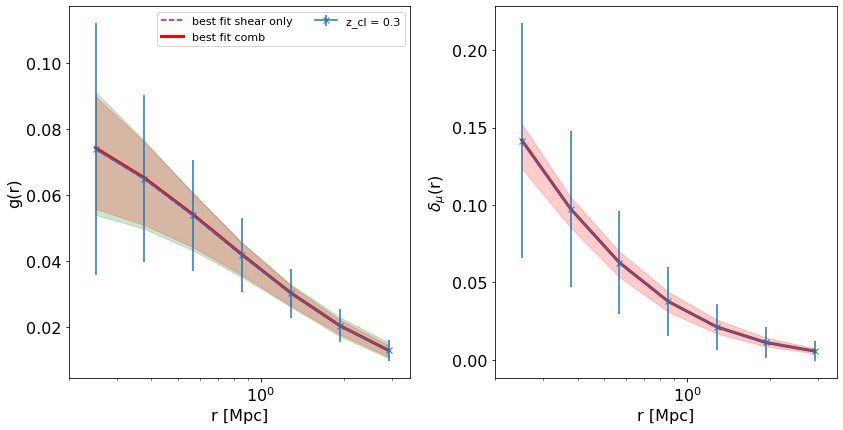

In [334]:
fig, ax = plt.subplots(1, 2,  figsize=(12,6), sharex=True, sharey=False)

i,j = 4,1

ax[0].errorbar(bin_center_s[:,j], model_s[:,i, j], yerr = noise_s[:,j], fmt='-x',  label = 'z_cl = '+str(lens_redshift[j]))
ax[0].plot(bin_center_s[:,j], model_BF_s,'m--', label='best fit shear only')
ax[0].plot(bin_center_s[:,j], model_BF_s_comb,'r', lw=3, label='best fit comb')                 
ax[0].fill_between(bin_center_s[:,j], np.percentile(model_s_only, 16, axis=1),  np.percentile(model_s_only, 84, axis=1), alpha=0.2, color='green')
ax[0].fill_between(bin_center_s[:,j], np.percentile(model_s_comb, 16, axis=1),  np.percentile(model_s_comb, 84, axis=1), alpha=0.2, color='red')


ax[1].errorbar(bin_center_mu_lbg[:,j], model_mu_lbg[:,i, j], yerr = noise_mu_lbg[:,j], fmt='-x',  label = 'z_cl = '+str(lens_redshift[j]))
ax[1].plot(bin_center_mu_lbg[:,j], model_BF_mu_comb,'r', lw=3, label='best fit comb')
ax[1].fill_between(bin_center_mu_lbg[:,j], np.percentile(model_mu_comb, 16, axis=1),  np.percentile(model_mu_comb, 84, axis=1), alpha=0.2, color='red')


ax[0].set_xlim(0.2, 3.5)
ax[0].legend(ncol=2, fontsize='x-small', loc="best")
ax[0].set_xscale('log')

ax[0].set_ylabel('g(r)')

ax[1].set_ylabel('$\delta_{\mu}$(r)')


fig.tight_layout()

[ax[i].set_xlabel('r [' + radial_unit + ']') for i in [0,1]];